In [1]:
import xarray as xr
import numpy as np
import sys; sys.path.append('../')
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

# Drake Passage averages over the last 1000 days

In [2]:
from functools import cache
@cache
def interface(exp='R4-long/bare', lon=0, layer=None):
    if exp=='R32':
        ds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)
    else:
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/longmean_00029050.nc', decode_times=False)
        except:
            # Return NaNs instead
            print(f'Experiment /scratch/pp2681/mom6/Neverworld2/simulations/{exp} exploded')
            ds = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False, chunks={'time':1}).isel(time=slice(0,1)) * np.nan
                                                                                                                                                
    e = ds.e
    
    if lon is not None:
        # lon=0,15,30,45
        if lon == 0:
            e = e.isel(xh=0)
        else:
            e = e.interp(xh=lon)
    
    if layer is not None:
        # layer = 0 is ssh
        e = e.isel(zi=layer)

    return e.mean('time').compute()

import xgcm
@cache
def ACC(exp='R4-long/bare'):
    if exp=='R32':
        ds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots*.nc', decode_times=False).isel(time=slice(None,None,6))
        static = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False)
    else:
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-27,None))
        except:
            try:
                ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/snapshots_00029020.nc', decode_times=False).isel(time=slice(-27,None))
            except:
                return xr.DataArray([np.nan]*27)
        static = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/static.nc', decode_times=False)

    u = ds.u.sel(xq=0).load()
    h = ds.h.isel(xh=[0,-1]).load()
    h_interp = (h.isel(xh=0) + h.isel(xh=-1)) * 0.5
    dyCu = static.dyCu.sel(xq=0).load()

    transport = u*h_interp*dyCu
    
    return transport.sum(['yh', 'zl']) * 1e-6

In [3]:
def interfaces(exp='R4-long/bare', lon=0, layer=None, lat_max=None):
    '''
    Simple wrapper returning hires and lores interfaces
    '''
    hires = interface('R32', lon=lon, layer=layer).sel(yh=slice(None,lat_max))
    lores = interface(exp, lon=lon, layer=layer).sel(yh=slice(None,lat_max))

    if lon is None:
        factor = len(hires.xh) // len(lores.xh)
        return hires.coarsen({'xh': factor, 'yh': factor}).mean(), lores
    elif layer is None:
        return hires.interp(yh=lores.yh), lores
    else:
        print('Not implemented')

def rmse(hires, lores):
    error = (lores - hires)
    if 'zi' in error.dims:
        error = error.isel(zi=slice(0,15))
    RMSE = np.sqrt((error**2).mean()) # RMSE in metres
    return round(float(RMSE),3)

In [4]:
def plot_interfaces(hires, lores):
    for zi in range(15):
        lores.isel(zi=zi).plot(ls='--', color='blue', lw=2)
        hires.isel(zi=zi).plot(ls='-', color='k', lw=2, alpha=0.5)
    hires.isel(zi=-1).plot(color='k') # show bathymetry 
    
    RMSE = rmse(hires,lores)
    plt.text(0.7,0.1,'RMSE=\n'+"{:.1f}".format(RMSE)+'$\,\mathrm{m}$', fontsize=15, transform = plt.gca().transAxes)
    plt.xlabel('Latitude, $^{\circ}\mathrm{S}$')
    plt.yticks(np.arange(-4000,1000,1000), np.arange(4000,-1000,-1000))
    plt.ylabel('Depth, $\mathrm{m}$')
    plt.title('')

In [43]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
def plot_timeseries(exps=['R1-long/bare-0.2-Sadourny'], labels=None, tmax=30000):
    plt.figure(figsize=(10,10))
    if labels is None:
        labels=exps
    for exp, label in zip(exps, labels):
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/ocean.stats.nc', decode_times=False)
        except:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/ocean.stats.nc', decode_times=False)
        plt.subplot(3,1,1)
        ds.max_CFL_lin.plot(lw=2)
        plt.xlabel('Days')
        ticks = [0,int(tmax/3),int(tmax*2/3),int(tmax)]
        plt.xticks(ticks,ticks)
        plt.xlim([0,tmax])
        plt.grid()

        plt.subplot(3,1,2)
        (ds.KE.sum('Layer')).plot(lw=2)
        plt.xlabel('Days')
        plt.ylabel('KE, Joules')
        plt.xticks(ticks,ticks)
        plt.axhline(y=2.45e+18, color='k')
        plt.xlim([0,tmax])
        plt.grid()

        plt.subplot(3,1,3)
        (ds.APE.sum('Interface')).plot(label=label, lw=2)
        plt.xlabel('Days')
        plt.ylabel('APE, Joules')
        plt.xticks(ticks,ticks)
        plt.axhline(y=0.958e+20, color='k')
        plt.xlim([0,tmax])
        plt.grid()
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1,1))

In [41]:
# ds1 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/May22-smooth-Coriolis/output/ocean_stats_early.nc', decode_times=False)
# ds2 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/May22-smooth-Coriolis/output/ocean_stats_late.nc', decode_times=False)
# print(ds1.Time.sel(Time=slice(None,22000-1e-6))[-1].values)
# print(ds2.Time[0].values)
# ds = xr.concat([ds1.sel(Time=slice(None,22000-1e-6)), ds2], 'Time')
# ds.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/May22-smooth-Coriolis/output/ocean.stats.nc')

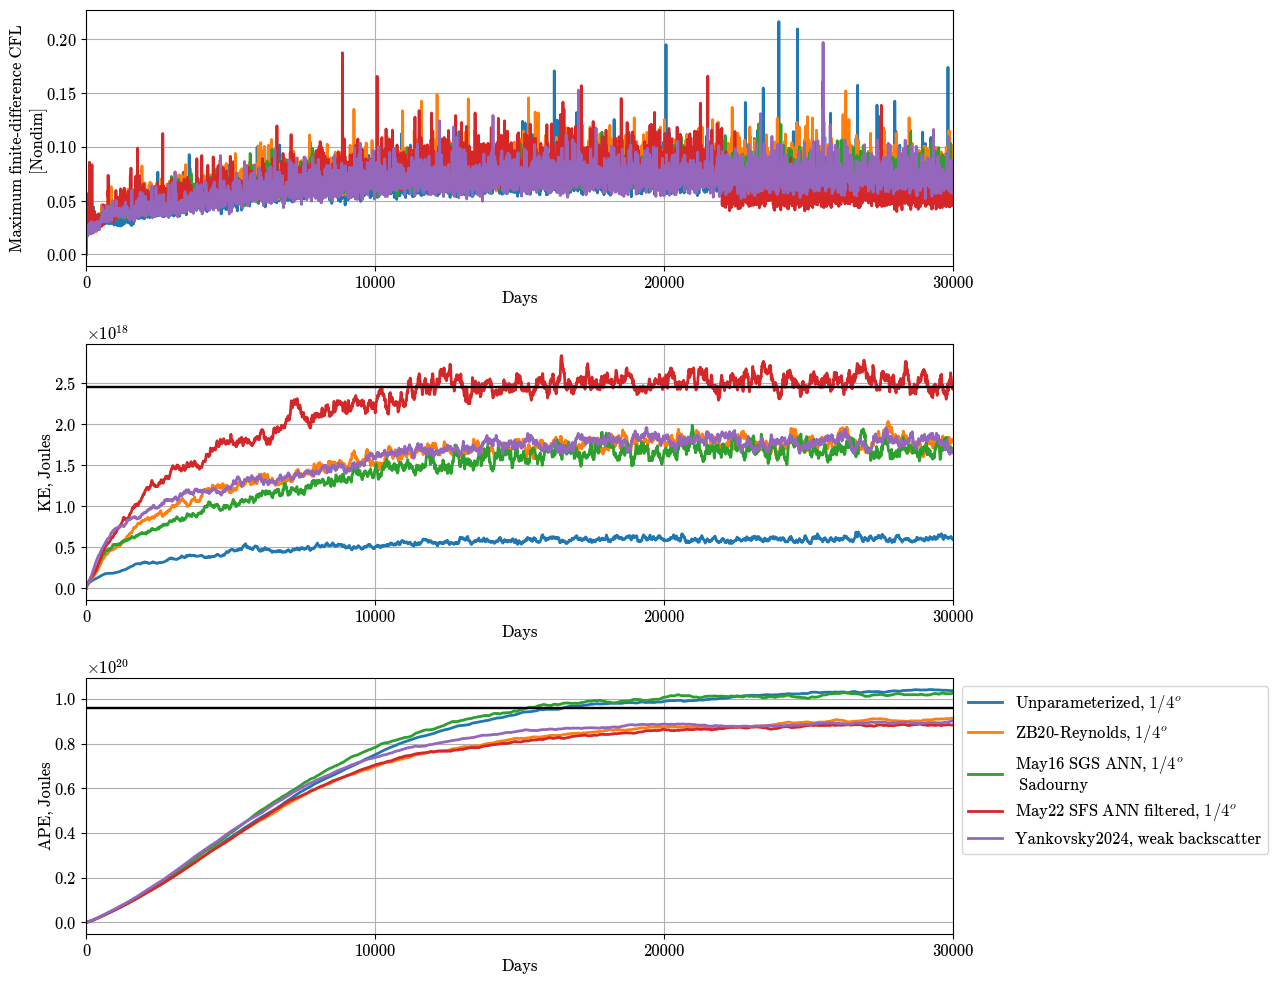

In [47]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
plot_timeseries(['R4-long/bare',
                 'R4-long/Reynolds-newest-code',
                 'R4-ANN/May-16-Cs-0.01',
                 'R4-ANN/May22-smooth-Coriolis',
                 'R4-long/Yankovsky23-0.3'], 
                ['Unparameterized, $1/4^o$', 
                  'ZB20-Reynolds, $1/4^o$',
                  'May16 SGS ANN, $1/4^o$\n Sadourny', 
                  'May22 SFS ANN filtered, $1/4^o$',
                  'Yankovsky2024, weak backscatter'
                ])

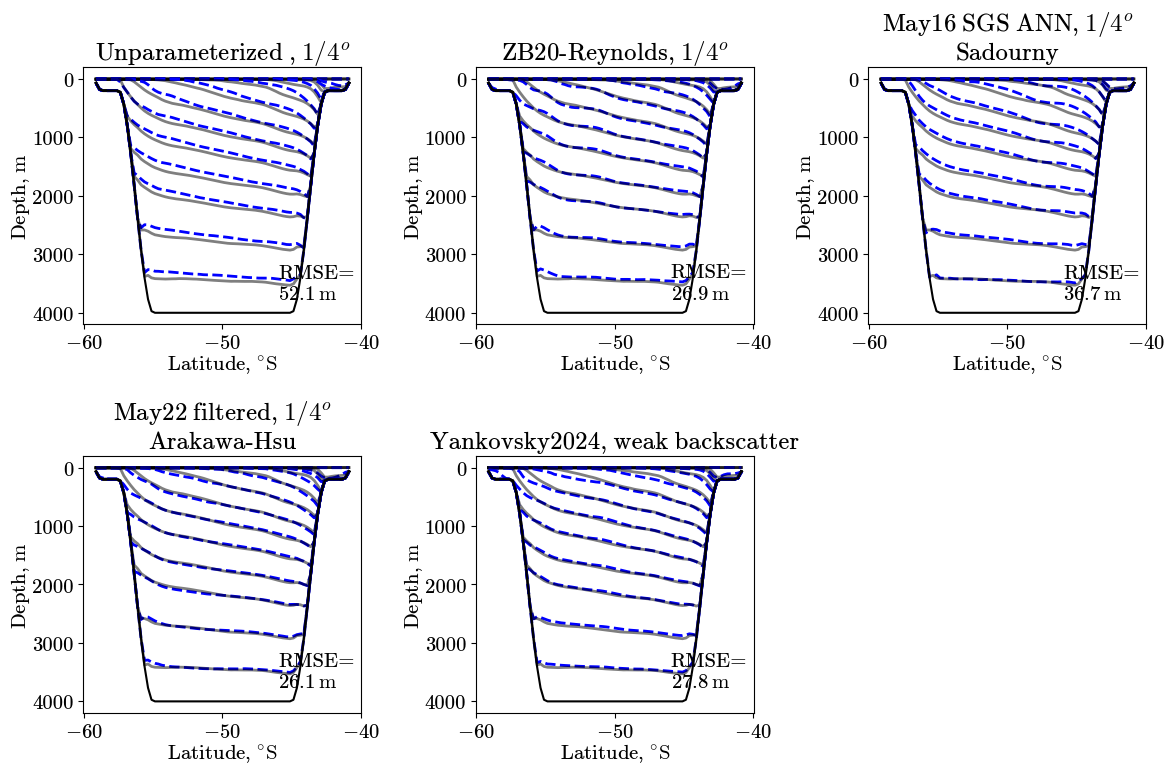

In [50]:
default_rcParams({'figure.subplot.wspace': 0.15, 'figure.subplot.hspace': 0.15, 'font.size': 15})
plt.figure(figsize=(12,8))
kw = {'lon': 0, 'lat_max': None}
plt.subplot(2,3,1)
plot_interfaces(*interfaces('R4-long/bare', **kw))
plt.title('Unparameterized , $1/4^o$')
plt.subplot(2,3,2)
plot_interfaces(*interfaces('R4-long/Reynolds-newest-code', **kw))
plt.title('ZB20-Reynolds, $1/4^o$')
plt.subplot(2,3,3)
plot_interfaces(*interfaces('R4-ANN/May-16-Cs-0.01', **kw))
plt.title('May16 SGS ANN, $1/4^o$\nSadourny')
plt.subplot(2,3,4)
plot_interfaces(*interfaces('R4-ANN/May22-smooth-Coriolis', **kw))
plt.title('May22 filtered, $1/4^o$\nArakawa-Hsu')
plt.subplot(2,3,5)
plot_interfaces(*interfaces('R4-long/Yankovsky23-0.3', **kw))
plt.title('Yankovsky2024, weak backscatter')
plt.tight_layout()

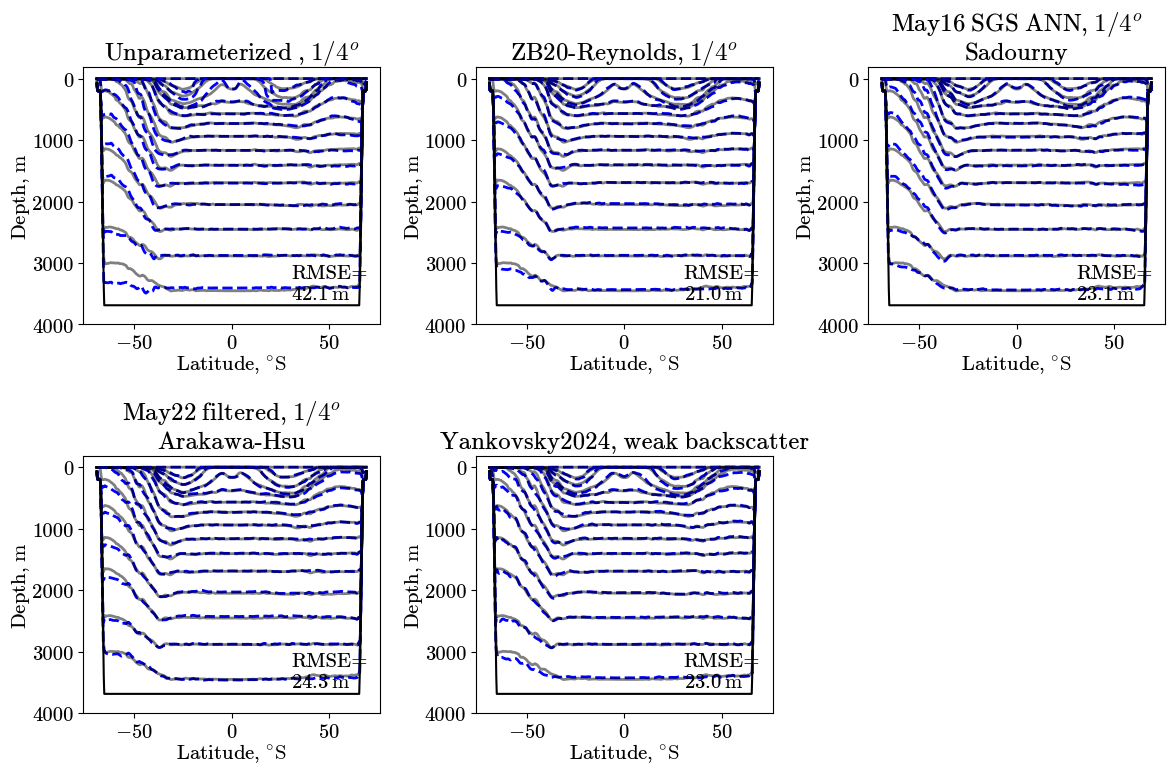

In [51]:
default_rcParams({'figure.subplot.wspace': 0.15, 'figure.subplot.hspace': 0.15, 'font.size': 15})
plt.figure(figsize=(12,8))
kw = {'lon': 15, 'lat_max': None}
plt.subplot(2,3,1)
plot_interfaces(*interfaces('R4-long/bare', **kw))
plt.title('Unparameterized , $1/4^o$')
plt.subplot(2,3,2)
plot_interfaces(*interfaces('R4-long/Reynolds-newest-code', **kw))
plt.title('ZB20-Reynolds, $1/4^o$')
plt.subplot(2,3,3)
plot_interfaces(*interfaces('R4-ANN/May-16-Cs-0.01', **kw))
plt.title('May16 SGS ANN, $1/4^o$\nSadourny')
plt.subplot(2,3,4)
plot_interfaces(*interfaces('R4-ANN/May22-smooth-Coriolis', **kw))
plt.title('May22 filtered, $1/4^o$\nArakawa-Hsu')
plt.subplot(2,3,5)
plot_interfaces(*interfaces('R4-long/Yankovsky23-0.3', **kw))
plt.title('Yankovsky2024, weak backscatter')
plt.tight_layout()

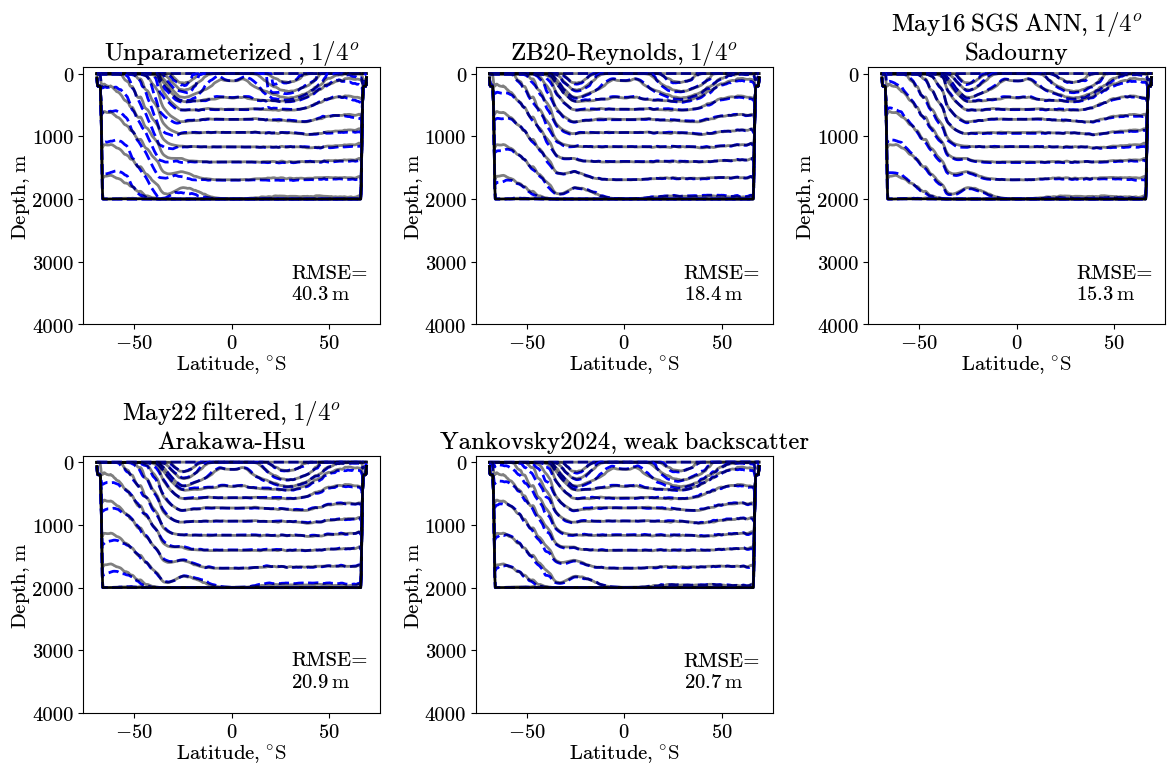

In [52]:
default_rcParams({'figure.subplot.wspace': 0.15, 'figure.subplot.hspace': 0.15, 'font.size': 15})
plt.figure(figsize=(12,8))
kw = {'lon': 30, 'lat_max': None}
plt.subplot(2,3,1)
plot_interfaces(*interfaces('R4-long/bare', **kw))
plt.title('Unparameterized , $1/4^o$')
plt.subplot(2,3,2)
plot_interfaces(*interfaces('R4-long/Reynolds-newest-code', **kw))
plt.title('ZB20-Reynolds, $1/4^o$')
plt.subplot(2,3,3)
plot_interfaces(*interfaces('R4-ANN/May-16-Cs-0.01', **kw))
plt.title('May16 SGS ANN, $1/4^o$\nSadourny')
plt.subplot(2,3,4)
plot_interfaces(*interfaces('R4-ANN/May22-smooth-Coriolis', **kw))
plt.title('May22 filtered, $1/4^o$\nArakawa-Hsu')
plt.subplot(2,3,5)
plot_interfaces(*interfaces('R4-long/Yankovsky23-0.3', **kw))
plt.title('Yankovsky2024, weak backscatter')
plt.tight_layout()

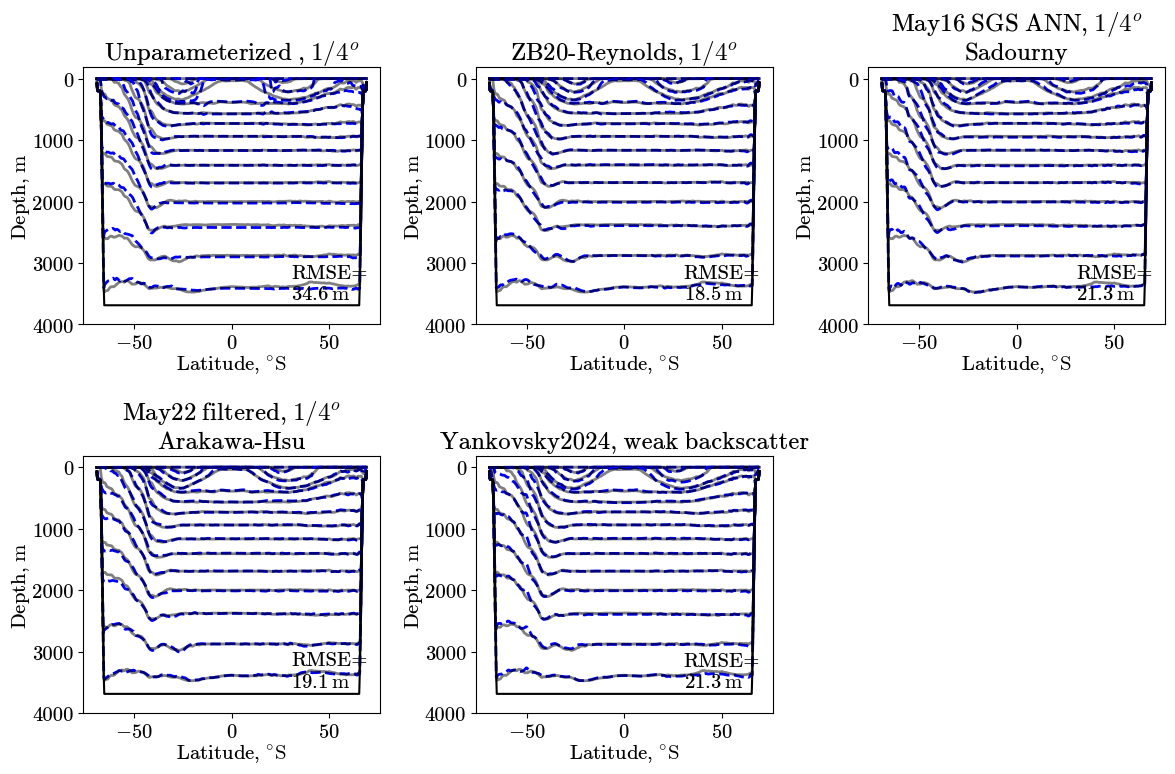

In [53]:
default_rcParams({'figure.subplot.wspace': 0.15, 'figure.subplot.hspace': 0.15, 'font.size': 15})
plt.figure(figsize=(12,8))
kw = {'lon': 45, 'lat_max': None}
plt.subplot(2,3,1)
plot_interfaces(*interfaces('R4-long/bare', **kw))
plt.title('Unparameterized , $1/4^o$')
plt.subplot(2,3,2)
plot_interfaces(*interfaces('R4-long/Reynolds-newest-code', **kw))
plt.title('ZB20-Reynolds, $1/4^o$')
plt.subplot(2,3,3)
plot_interfaces(*interfaces('R4-ANN/May-16-Cs-0.01', **kw))
plt.title('May16 SGS ANN, $1/4^o$\nSadourny')
plt.subplot(2,3,4)
plot_interfaces(*interfaces('R4-ANN/May22-smooth-Coriolis', **kw))
plt.title('May22 filtered, $1/4^o$\nArakawa-Hsu')
plt.subplot(2,3,5)
plot_interfaces(*interfaces('R4-long/Yankovsky23-0.3', **kw))
plt.title('Yankovsky2024, weak backscatter')
plt.tight_layout()

In [55]:
print(rmse(*interfaces('R4-long/bare',lon=None,layer=0)))

0.101


In [56]:
print(rmse(*interfaces('R4-long/Reynolds-newest-code',lon=None,layer=0)))

0.08


In [57]:
print(rmse(*interfaces('R4-ANN/May-16-Cs-0.01',lon=None,layer=0)))

0.077


In [58]:
print(rmse(*interfaces('R4-ANN/May22-smooth-Coriolis',lon=None,layer=0)))

0.085


In [59]:
print(rmse(*interfaces('R4-long/Yankovsky23-0.3',lon=None,layer=0)))

0.071
